### Testing GA Hyperparameter Tuning

Dependencies:
```
numpy
pandas 
matplotlib
sklearn
```

In [ ]:
from genetic_algorithm import GeneticAlgorithm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_diabetes, load_breast_cancer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, HalvingGridSearchCV
from sklearn.linear_model import LogisticRegression


##### Load data 

In [ ]:
def prepare_data(X, y):
   # Splits and scales the data
   X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
   y_train_binary = y_train # np.where(y_train > np.median(y_train), 1, 0)
   y_test_binary = y_test # np.where(y_test > np.median(y_train), 1, 0)
   scaler = StandardScaler()
   X_train_scaled = scaler.fit_transform(X_train)
   X_test_scaled = scaler.transform(X_test)
   return X_train_scaled, X_test_scaled, y_train_binary, y_test_binary

In [ ]:
breast_cancer = load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target

X_train_scaled, X_test_scaled, y_train_binary, y_test_binary = prepare_data(X, y)

## Testing

For testing, 3 different models were used
- Decision Trees
- SVM
- Logistic Regression

3 Different Hyperparameter tuning methods were used
- Our Genetic Algorithm Hyperparameter Tuning Method 
- Grid Search
- Randomized Search

For each model, across all of the hyperparameter tuning methods, the same set of parameters was used for each one and the same parameters were used for each genetic algorithm

In [ ]:
# Helper fn
def get_analytics(y_test, y_pred):
   accuracy = accuracy_score(y_test, y_pred)
   precision = precision_score(y_test, y_pred, average='weighted')
   recall = recall_score(y_test, y_pred, average='weighted')
   f1 = f1_score(y_test, y_pred, average='weighted')
   
   return accuracy, precision, recall, f1
   

### Decision Tree

In [232]:
# Using the same params for Grid Search and Genetic Algorithm
# decision tree param space
param_space_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': range(1, 20),
    'min_samples_split': range(2, 20),
    'min_samples_leaf': range(1, 20),
    'max_features': [None, 'sqrt', 'log2', 0.5, 0.7],
    'max_leaf_nodes': [None, 10, 20, 30, 40, 50],
    'splitter': ['best', 'random'],
    'class_weight': [None, 'balanced'],
}

##### Genetic Algorithm

In [ ]:
dt1 = DecisionTreeClassifier()

accuracies = []
precisions = []
recalls = []
f1s = []

ga_dt_scores = []
ga_dt_times = []
# Run Genetic Algorithm 50 times to capture the average score and time
for i in range(50):
    ga_dt = GeneticAlgorithm(modelToTune=dt1, 
                        param_space=param_space_dt, 
                        verbose=0,
                        population_size=100,
                        generations=10,
                        mutation_prob=0.2,
                        crossover_prob=0.75,
                        tournament_size=20,
                        cv=5,
                        scoring='accuracy'
                        ) 
    start = time.time()
    ga_dt.run(X_train_scaled, y_train_binary)
    end = time.time()
    
    dt1_test = DecisionTreeClassifier(**ga_dt.best_params_)
    dt1_test.fit(X_train_scaled, y_train_binary)
    y_pred = dt1_test.predict(X_test_scaled)
    accuracy, precision, recall, f1 = get_analytics(y_test_binary, y_pred)
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)
    
    # save score and time in a list
    ga_dt_scores.append(ga_dt.best_score_)
    ga_dt_times.append(end - start)
    
# Print the average score and time
print('Genetic Algorithm with Decision Tree')
print('--------------------------------------------------')
print(f"Average score (train): {np.mean(ga_dt_scores)}")
print(f"Average time (train): {np.mean(ga_dt_times)} seconds")
print('')
print(f"Average accuracy (test): {np.mean(accuracies)}")
print(f"Average precision (test): {np.mean(precisions)}")
print(f"Average recall (test): {np.mean(recalls)}")
print(f"Average f1 score (test): {np.mean(f1s)}")

Genetic Algorithm with Decision Tree
--------------------------------------------------
Average score (train): 0.9604395604395604
Average time (train): 8.145577907562256 seconds

Average accuracy (test): 0.9385964912280702
Average precision (test): 0.938457254246728
Average recall (test): 0.9385964912280702
Average f1 score (test): 0.9384499917007656


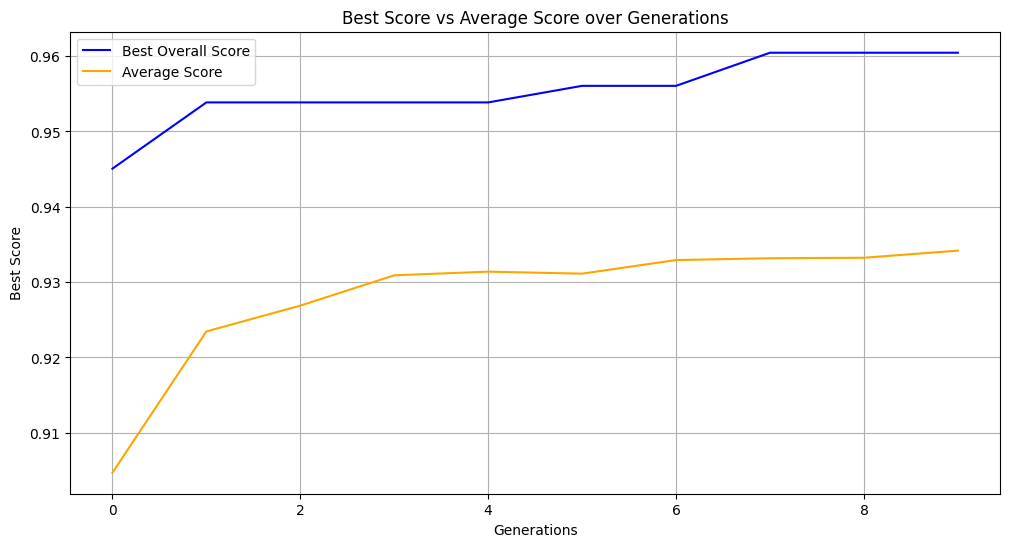

In [ ]:
# Creating a graph of best scores over time 
ga_dt_scores = ga_dt.history_
df = pd.DataFrame(ga_dt_scores)

grid_generations = df.shape[0]
plt.figure(figsize=(12, 6))
plt.plot(df['generation'], df['best_score'], label='Best Overall Score', color='blue')
plt.plot(df['generation'], df['avg_score'], label='Average Score', color='orange')
plt.xlabel('Generations')
plt.ylabel('Best Score')
plt.title('Best Score vs Average Score over Generations')
plt.legend()
plt.grid()
plt.show()

##### Grid Search

In [ ]:
dt2 = DecisionTreeClassifier()

grid = GridSearchCV(dt2, param_space_dt, cv=5, n_jobs=-1, scoring='accuracy')
start2 = time.time()
grid.fit(X_train_scaled, y_train_binary)
end2 = time.time()

Grid Search took 1585.29 seconds
Best parameters from Grid Search: {'class_weight': None, 'criterion': 'gini', 'max_depth': 8, 'max_features': None, 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_samples_split': 16, 'splitter': 'random'}
Best score from Grid Search: 0.9692


In [192]:
print(f"Score (train): {grid.best_score_}")
print(f"Time (train): {end2 - start2} seconds")

# Test the model
y_pred = grid.predict(X_test_scaled)
accuracy, precision, recall, f1 = get_analytics(y_test_binary, y_pred)
print(f"Accuracy (test): {accuracy}")
print(f"Precision (test): {precision}")
print(f"Recall (test): {recall}")
print(f"F1 Score (test): {f1}")

Score (train): 0.9692307692307691
Time (train): 1585.2911586761475 seconds
Accuracy (test): 0.9473684210526315
Precision (test): 0.9488079172289698
Recall (test): 0.9473684210526315
F1 Score (test): 0.9468057045386604


##### Randomized Search

In [ ]:
dt3 = DecisionTreeClassifier()

accuracies = []
precisions = []
recalls = []
f1s = []

dt3_best_times = []
dt3_best_scores = []
for i in range(50):
    rand = RandomizedSearchCV(dt3, param_space_dt, n_iter=1000, cv=5, n_jobs=-1, scoring='accuracy')
    start3 = time.time()
    rand.fit(X_train_scaled, y_train_binary)
    end3 = time.time()
    # save score and time in a list
    dt3_best_scores.append(rand.best_score_)
    dt3_best_times.append(end3 - start3)
    
    dt3_test = rand.best_estimator_
    y_pred3 = dt3_test.predict(X_test_scaled)
    acc, prec, rec, f1 = get_analytics(y_test_binary, y_pred3)
    accuracies.append(acc)
    precisions.append(prec)
    recalls.append(rec)
    f1s.append(f1)
    
# Print the average score and time
print('Randomized Search with Decision Tree')
print('--------------------------------------------------')
print(f"Average score (train): {np.mean(dt3_best_scores)}")
print(f"Average time (train): {np.mean(dt3_best_times)} seconds")   
print('')
print(f"Average accuracy (test): {np.mean(accuracies)}")
print(f"Average precision (test): {np.mean(precisions)}")
print(f"Average recall (test): {np.mean(recalls)}")
print(f"Average f1 (test): {np.mean(f1s)}")

Randomized Search with Decision Tree
--------------------------------------------------
Average score (train): 0.9507692307692308
Average time (train): 1.3868255376815797 seconds

Average accuracy (test): 0.9517543859649124
Average precision (test): 0.9521122183299913
Average recall (test): 0.9517543859649124
Average f1 (test): 0.951640311229345


### Random Forest

In [ ]:
# large param grid for search 
param_space_rf = {
    'criterion': ['gini', 'entropy'],
    'max_depth': range(1, 20),
    'n_estimators': range(50, 200, 50),
    'min_samples_split': range(2, 20),
    'min_samples_leaf': range(1, 20),
    'max_features': [None, 'sqrt', 'log2', 0.5, 0.7],
    'max_leaf_nodes': [None, 10, 20, 30, 40, 50],
    'class_weight': [None, 'balanced'],
}

##### Genetic Algorithm

In [ ]:
rf1 = RandomForestClassifier()

accuracies = []
precisions = []
recalls = []
f1s = []

rf1_scores = []
rf1_times = []
print("Iteration number:")
for i in range(50):
    #print(f"{i+1}", end=' ') # this is just for tracking progress
    ga = GeneticAlgorithm(modelToTune=rf1, 
                        param_space=param_space_rf, 
                        verbose=0,
                        population_size=20,
                        generations=20,
                        mutation_prob=0.75,
                        crossover_prob=0.5,
                        cv=5,
                        scoring='accuracy'
                        )
    start = time.time()
    ga.run(X_train_scaled, y_train_binary)
    end = time.time()
    
    rf1_test = RandomForestClassifier(**ga.best_params_)
    rf1_test.fit(X_train_scaled, y_train_binary)
    y_pred = rf1_test.predict(X_test_scaled)
    accuracy, precision, recall, f1 = get_analytics(y_test_binary, y_pred)
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)
    
    rf1_scores.append(ga.best_score_)
    rf1_times.append(end - start)
    
# Print the average score and time
print('Genetic Algorithm with Random Forest')
print('--------------------------------------------------')
print(f"Average score (train): {np.mean(rf1_scores)}")
print(f"Average time (train): {np.mean(rf1_times)} seconds")
print('')
print(f"Average accuracy (test): {np.mean(accuracies)}")
print(f"Average precision (test): {np.mean(precisions)}")
print(f"Average recall (test): {np.mean(recalls)}")
print(f"Average f1 score (test): {np.mean(f1s)}")

Iteration number:
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/iansmith/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/p9/9lr8n9g11g58d0xvc2yfc83w0000gn/T/ipykernel_21948/3743084993.py", line 24, in <module>
    ga.run(X_train_scaled, y_train_binary)
  File "/Users/iansmith/Documents/repos/CPSC544-Project/myModel/tryingStuff/genetic_algorithm.py", line 101, in run
    for gen in range(self.generations):
  File "/Users/iansmith/Documents/repos/CPSC544-Project/myModel/tryingStuff/genetic_algorithm.py", line 101, in <listcomp>
    for gen in range(self.generations):
  File "/Users/iansmith/Documents/repos/CPSC544-Project/myModel/tryingStuff/genetic_algorithm.py", line 52, in _evaluate_individual
  File "/Users/iansmith/Library/Python/3.9/lib/python/site-packages/sklearn/base.py", line 283, in set_params
    raise ValueError(
ValueError: Invalid parameter 'splitter' for esti

In [180]:
print('Genetic Algorithm with Random Forest')
print('--------------------------------------------------')
print(f"Average score (train): {np.mean(rf1_scores)}")
print(f"Average time (train): {np.mean(rf1_times)} seconds")
print('')
print(f"Average accuracy (test): {np.mean(accuracies)}")
print(f"Average precision (test): {np.mean(precisions)}")
print(f"Average recall (test): {np.mean(recalls)}")
print(f"Average f1 score (test): {np.mean(f1s)}")

Genetic Algorithm with Random Forest
--------------------------------------------------
Average score (train): 0.9708131868131867
Average time (train): 268.77471274375915 seconds

Average accuracy (test): 0.9629824561403507
Average precision (test): 0.9631378235375722
Average recall (test): 0.9629824561403507
Average f1 score (test): 0.9628442565919346


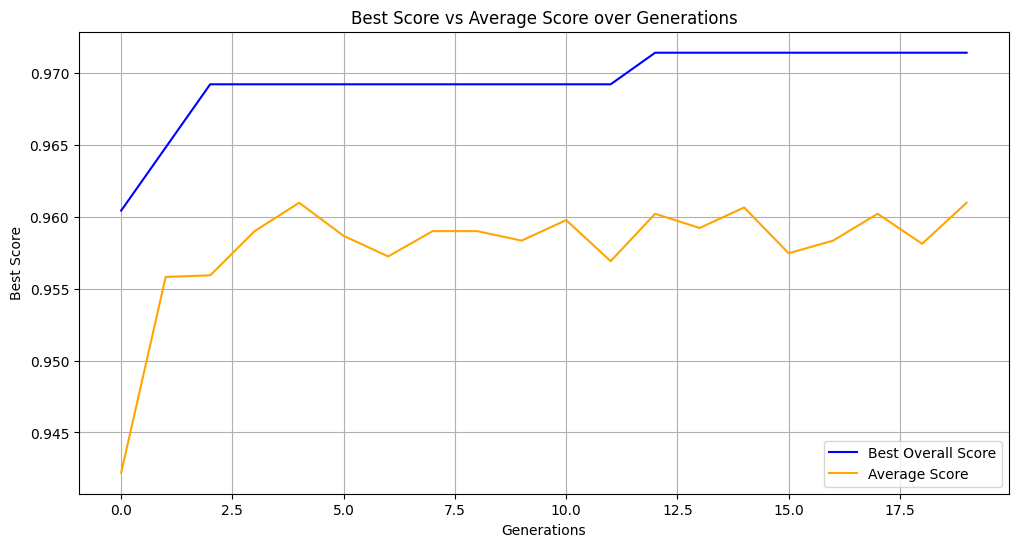

In [216]:
# Creating a graph of best scores over time 
ga_scores = ga.history_
df = pd.DataFrame(ga_scores)
df

grid_generations = df.shape[0]
plt.figure(figsize=(12, 6))
plt.plot(df['generation'], df['best_score'], label='Best Overall Score', color='blue')
plt.plot(df['generation'], df['avg_score'], label='Average Score', color='orange')
plt.xlabel('Generations')
plt.ylabel('Best Score')
plt.title('Best Score vs Average Score over Generations')
plt.legend()
plt.grid()
plt.show()

##### Grid Search

In [ ]:
rf2 = RandomForestClassifier()
grid = GridSearchCV(rf2, param_space, cv=5, n_jobs=-1, scoring='accuracy')
start2 = time.time()
grid.fit(X_train_scaled, y_train_binary)
end2 = time.time()
print(f"Grid Search took {end2 - start2:.2f} seconds")
print(f"Best parameters from Grid Search: {grid.best_params_}")
print(f"Best score from Grid Search: {grid.best_score_:.4f}")
rf2 = grid.best_estimator_
y_pred2 = rf2.predict(X_test_scaled)
acc, prec, rec, f1 = get_analytics(y_test_binary, y_pred2)
print(f"Accuracy: {acc}")
print(f"Precision: {prec}")
print(f"Recall: {rec}")
print(f"F1 Score: {f1}")

##### Randomized Search

In [179]:
rf3 = RandomForestClassifier()

accuracies = []
precisions = []
recalls = []
f1s = []

ga_scores = []
ga_times = []

for i in range(50):
    rand = RandomizedSearchCV(rf3, param_space, n_iter=400, cv=5, n_jobs=-1, scoring='accuracy')
    start = time.time()
    rand.fit(X_train_scaled, y_train_binary)
    end = time.time()
    # save score and time in a list
    ga_scores.append(rand.best_score_)
    ga_times.append(end - start)
    
    rf3_test = rand.best_estimator_
    y_pred3 = rf3_test.predict(X_test_scaled)
    acc, prec, rec, f1 = get_analytics(y_test_binary, y_pred3)
    accuracies.append(acc)
    precisions.append(prec)
    recalls.append(rec)
    f1s.append(f1)
    
# Print the average score and time
print('Randomized Search with Random Forest')
print('--------------------------------------------------')
print(f"Average score (train): {np.mean(ga_scores)}")
print(f"Average time (train): {np.mean(ga_times)} seconds")
print('')
print(f"Average accuracy (test): {np.mean(accuracies)}")
print(f"Average precision (test): {np.mean(precisions)}")
print(f"Average recall (test): {np.mean(recalls)}")
print(f"Average f1 (test): {np.mean(f1s)}")


Randomized Search with Random Forest
--------------------------------------------------
Average score (train): 0.9663736263736264
Average time (train): 32.41342860221863 seconds

Average accuracy (test): 0.9629824561403507
Average precision (test): 0.9631378235375722
Average recall (test): 0.9629824561403507
Average f1 (test): 0.9628442565919346


### Support Vector Machine

In [33]:
from sklearn.svm import SVC

In [35]:
svm_param_space = {
    'C': list(np.logspace(-5, 3, 15)), 
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto'],
    'degree': range(2, 10),  
    'coef0': list(np.linspace(0, 1, 5)), 
    'shrinking': [True, False], 
    'tol': list(np.logspace(-5, -1, 5))  
}

##### Genetic Algorithm Search

In [ ]:
svm1 = SVC()

accuracies = []
precisions = []
recalls = []
f1s = []

ga_scores = []
ga_times = []

for i in range(50):
    ga_svm = GeneticAlgorithm(modelToTune=svm1,
                            param_space=svm_param_space,
                            verbose=0,
                            population_size=20,
                            generations=9,
                            mutation_prob=0.4,
                            crossover_prob=0.6,
                            tournament_size=2,
                            cv=5,
                            scoring='accuracy'
                            )
    start5 = time.time()
    ga_svm.run(X_train_scaled, y_train_binary)
    end5 = time.time()
    
    svm1_test = SVC(**ga_svm.best_params_)
    svm1_test.fit(X_train_scaled, y_train_binary)
    y_pred5 = svm1_test.predict(X_test_scaled)
    accuracy, precision, recall, f1 = get_analytics(y_test_binary, y_pred5)
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)
    
    # save score and time in a list
    ga_scores.append(ga_svm.best_score_)
    ga_times.append(end5 - start5)
    
# Print the average score and time
print('Genetic Algorithm with SVM')
print('--------------------------------------------------')
print(f"Average score from Genetic Algorithm (train): {np.mean(ga_scores)}")
print(f"Average time from Genetic Algorithm (train): {np.mean(ga_times)} seconds")
print('')
# Print the average accuracy, precision, recall, and f1 score
print(f"Average accuracy (test): {np.mean(accuracies)}")
print(f"Average precision (test): {np.mean(precisions)}")
print(f"Average recall (test): {np.mean(recalls)}")
print(f"Average f1 score (test): {np.mean(f1s)}")

                           

Genetic Algorithm with SVM
--------------------------------------------------
Average score from Genetic Algorithm (train): 0.9778021978021979
Average time from Genetic Algorithm (train): 1.5811544418334962 seconds

Average accuracy (test): 0.9807017543859647
Average precision (test): 0.9810932391862457
Average recall (test): 0.9807017543859647
Average f1 score (test): 0.9806195787929534


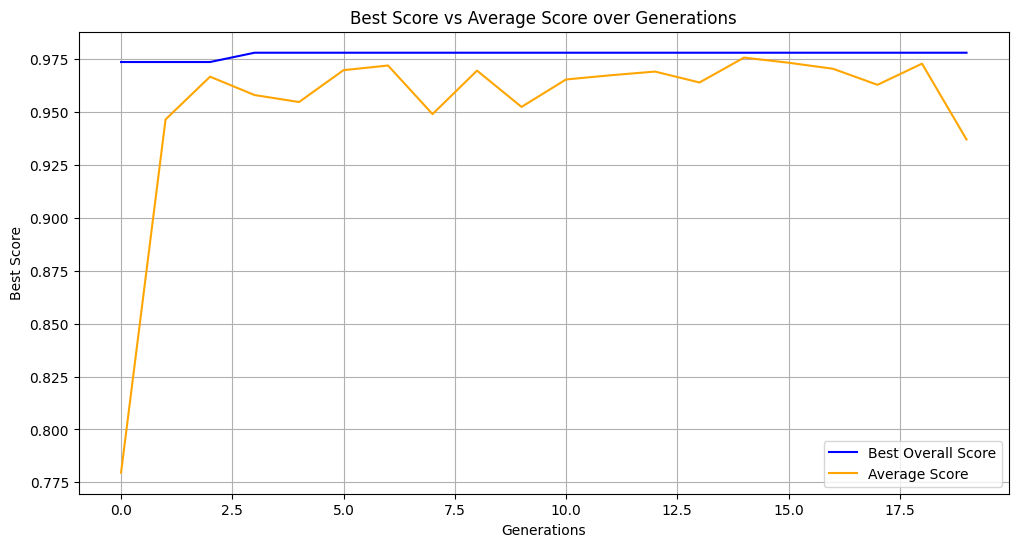

In [198]:
# Creating a graph of best scores over time 
ga_scores = ga_svm.history_
df = pd.DataFrame(ga_scores)
df

grid_generations = df.shape[0]
plt.figure(figsize=(12, 6))
plt.plot(df['generation'], df['best_score'], label='Best Overall Score', color='blue')
plt.plot(df['generation'], df['avg_score'], label='Average Score', color='orange')
plt.xlabel('Generations')
plt.ylabel('Best Score')
plt.title('Best Score vs Average Score over Generations')
plt.legend()
plt.grid()
plt.show()

##### Grid Search

In [195]:
svm2 = SVC()
grid_svm = GridSearchCV(svm2, svm_param_space, cv=5, n_jobs=-1, scoring='accuracy')
start6 = time.time()
grid_svm.fit(X_train_scaled, y_train_binary)
end6 = time.time()

svm2 = grid_svm.best_estimator_
y_pred2 = svm2.predict(X_test_scaled)
acc, prec, rec, f1 = get_analytics(y_test_binary, y_pred2)


print(f"Time (train): {end6 - start6:.2f} seconds")
print(f"Best score (train): {grid_svm.best_score_}")
print('')
print(f"Accuracy (test): {acc}")
print(f"Precision (test): {prec}")
print(f"Recall (test): {rec}")
print(f"F1 Score (test): {f1}")

Time (train): 111.00 seconds
Best score (train): 0.9824175824175825

Accuracy (test): 0.9824561403508771
Precision (test): 0.9829367940398942
Recall (test): 0.9824561403508771
F1 Score (test): 0.9823691172375383


Accuracy:  0.7415730337078652
Precision:  0.740889766170665
Recall:  0.7415730337078652
F1 Score:  0.7403767664085832
Classification Report:
{'0': {'precision': 0.75, 'recall': 0.7959183673469388, 'f1-score': 0.7722772277227723, 'support': 49.0}, '1': {'precision': 0.7297297297297297, 'recall': 0.675, 'f1-score': 0.7012987012987013, 'support': 40.0}, 'accuracy': 0.7415730337078652, 'macro avg': {'precision': 0.7398648648648649, 'recall': 0.7354591836734694, 'f1-score': 0.7367879645107368, 'support': 89.0}, 'weighted avg': {'precision': 0.740889766170665, 'recall': 0.7415730337078652, 'f1-score': 0.7403767664085832, 'support': 89.0}}


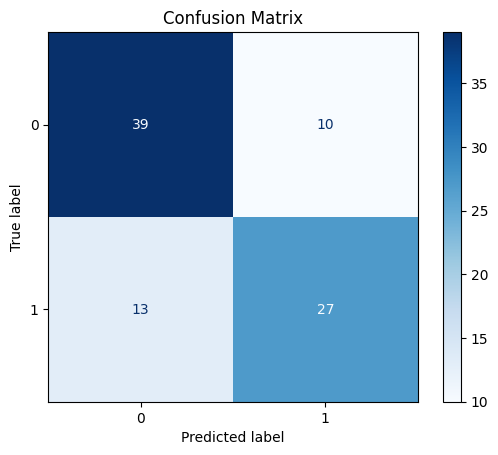

##### Randomized Search

In [ ]:
svm3 = SVC()

accuracies = []
precisions = []
recalls = []
f1s = []

svm3_best_times = []
svm3_best_scores = []

for i in range(50):
    rand_svm = RandomizedSearchCV(svm3, svm_param_space, n_iter=400, cv=5, n_jobs=-1, scoring='accuracy')
    start7 = time.time()
    rand_svm.fit(X_train_scaled, y_train_binary)
    end7 = time.time()
    # save score and time in a list
    svm3_best_scores.append(rand_svm.best_score_)
    svm3_best_times.append(end7 - start7)
    svm3_test = rand_svm.best_estimator_
    y_pred3 = svm3_test.predict(X_test_scaled)
    acc, prec, rec, f1 = get_analytics(y_test_binary, y_pred3)
    accuracies.append(acc)
    precisions.append(prec)
    recalls.append(rec)
    f1s.append(f1)
# Print the average score and time
print('Randomized Search with SVM')
print('--------------------------------------------------')
print(f"Average score (train): {np.mean(svm3_best_scores)}")
print(f"Average time (train): {np.mean(svm3_best_times)} seconds")
print('')
print(f"Average accuracy (test): {np.mean(accuracies)}")
print(f"Average precision (test): {np.mean(precisions)}")
print(f"Average recall (test): {np.mean(recalls)}")
print(f"Average f1 (test): {np.mean(f1s)}")


Randomized Search with SVM
--------------------------------------------------
Average score (train): 0.9787692307692307
Average time (train): 0.5995930910110474 seconds

Average accuracy (test): 0.9791228070175438
Average precision (test): 0.9794751433377965
Average recall (test): 0.9791228070175438
Average f1 (test): 0.9790488489838336


##### Halving Grid Search

In [44]:
svm4 = SVC()
halving_grid_svm = HalvingGridSearchCV(svm4, svm_param_space, cv=5, n_jobs=-1, scoring='accuracy')
start8 = time.time()
halving_grid_svm.fit(X_train_scaled, y_train_binary)
end8 = time.time()
print(f"Halving Grid Search for SVM took {end8 - start8:.2f} seconds")
print(f"Best parameters from Halving Grid Search for SVM: {halving_grid_svm.best_params_}")
print(f"Best score from Halving Grid Search for SVM: {halving_grid_svm.best_score_}")

Halving Grid Search for SVM took 194.74 seconds
Best parameters from Halving Grid Search for SVM: {'C': np.float64(1.389495494373136), 'coef0': np.float64(0.25), 'degree': 6, 'gamma': 'auto', 'kernel': 'sigmoid', 'shrinking': True, 'tol': np.float64(0.001)}
Best score from Halving Grid Search for SVM: 0.7582539682539682


Accuracy:  0.6853932584269663
Precision:  0.6843148850314816
Recall:  0.6853932584269663
F1 Score:  0.6845059060789398
Classification Report:
{'0': {'precision': 0.7058823529411765, 'recall': 0.7346938775510204, 'f1-score': 0.72, 'support': 49.0}, '1': {'precision': 0.6578947368421053, 'recall': 0.625, 'f1-score': 0.6410256410256411, 'support': 40.0}, 'accuracy': 0.6853932584269663, 'macro avg': {'precision': 0.681888544891641, 'recall': 0.6798469387755102, 'f1-score': 0.6805128205128206, 'support': 89.0}, 'weighted avg': {'precision': 0.6843148850314816, 'recall': 0.6853932584269663, 'f1-score': 0.6845059060789398, 'support': 89.0}}


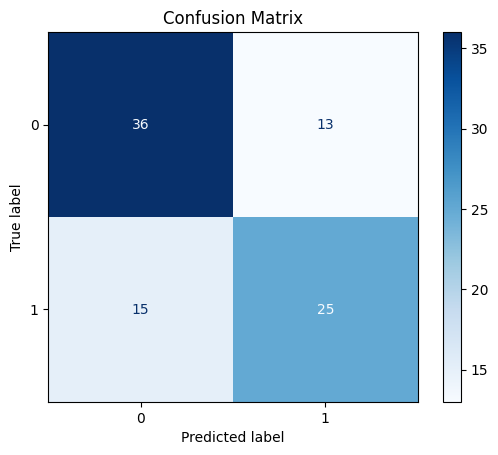

In [45]:
svm4 = halving_grid_svm.best_estimator_
y_pred4 = svm4.predict(X_test_scaled)
get_analytics(y_test_binary, y_pred4)

### Logistic Regression

Note: L1 penalty is not compatible with the GridSearchCV

In [ ]:
# Traditional searches only compatible with l2 penalty
logreg_param_space2 = {
    'C': list(np.logspace(-4, 4, 20)),
    'penalty': ['l2'],
    'solver': ['lbfgs', 'newton-cg', 'sag', 'saga', 'liblinear'],
    'max_iter': list(range(100, 2001, 100)),
    'tol': [1e-4, 1e-5, 1e-6],
    'class_weight': [None, 'balanced'],
    'fit_intercept': [True, False]
}


##### Genetic Algorithm Search

In [209]:
lr1 = LogisticRegression()

accuracies = []
precisions = []
recalls = []
f1s = []

lr1_best_times = []
lr1_best_scores = []

for i in range(1):
      ga_logreg = GeneticAlgorithm(
            modelToTune=lr1,
            param_space=logreg_param_space2,
            verbose=0,
            population_size=20,
            generations=20,
            mutation_prob=0.75,
            crossover_prob=0.5,
            cv=5,
            scoring='accuracy'
      )
      start9 = time.time()
      ga_logreg.run(X_train_scaled, y_train_binary)
      end9 = time.time()
      
      # save score and time in a list
      lr1_best_scores.append(ga_logreg.best_score_)
      lr1_best_times.append(end9 - start9)
      
      lr1_test = LogisticRegression(**ga_logreg.best_params_)
      lr1_test.fit(X_train_scaled, y_train_binary)
      y_pred = lr1_test.predict(X_test_scaled)
      
      accuracy, precision, recall, f1 = get_analytics(y_test_binary, y_pred)
      accuracies.append(accuracy)
      precisions.append(precision)
      recalls.append(recall)
      f1s.append(f1)

# Print the average score and time
print('Genetic Algorithm with Logistic Regression')
print('--------------------------------------------------')
print(f"Average score (train): {np.mean(lr1_best_scores)}")
print(f"Average time (train): {np.mean(lr1_best_times)} seconds")   
print('')
print(f"Average accuracy (test): {np.mean(accuracies)}")
print(f"Average precision (test): {np.mean(precisions)}")
print(f"Average recall (test): {np.mean(recalls)}")
print(f"Average f1 (test): {np.mean(f1s)}")
    


/Users/iansmith/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/iansmith/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/iansmith/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/iansmith/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/iansmith/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/iansmith/Library/P

Genetic Algorithm with Logistic Regression
--------------------------------------------------
Average score (train): 0.9780219780219781
Average time (train): 36.75732207298279 seconds

Average accuracy (test): 0.9736842105263158
Average precision (test): 0.9739576213260425
Average recall (test): 0.9736842105263158
Average f1 (test): 0.9737421322933159


/Users/iansmith/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/iansmith/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/iansmith/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/iansmith/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/iansmith/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/iansmith/Library/P

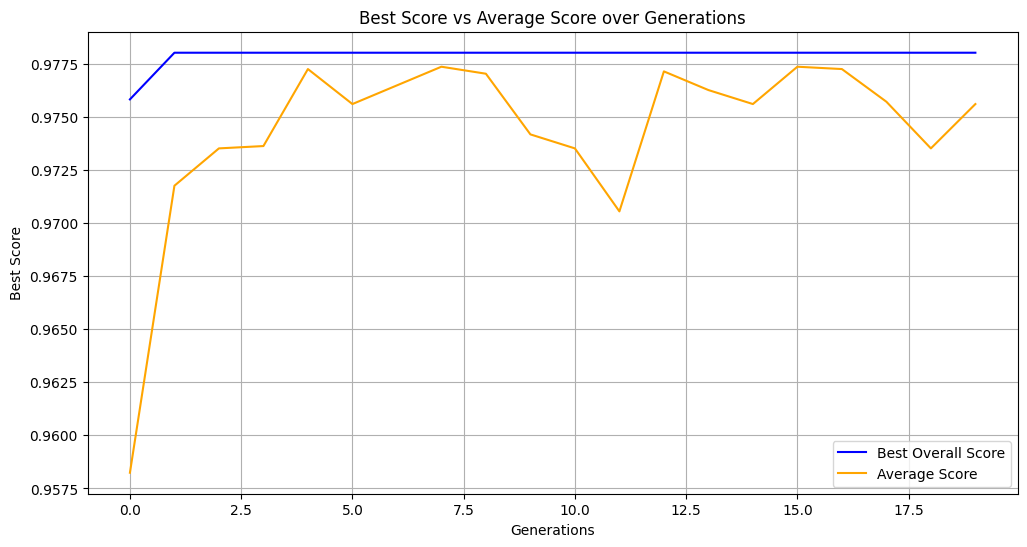

In [210]:
# Creating a graph of best scores over time 
ga_scores = ga_logreg.history_
df = pd.DataFrame(ga_scores)
df

grid_generations = df.shape[0]
plt.figure(figsize=(12, 6))
plt.plot(df['generation'], df['best_score'], label='Best Overall Score', color='blue')
plt.plot(df['generation'], df['avg_score'], label='Average Score', color='orange')
plt.xlabel('Generations')
plt.ylabel('Best Score')
plt.title('Best Score vs Average Score over Generations')
plt.legend()
plt.grid()
plt.show()

##### Grid Search

In [194]:
lr2 = LogisticRegression()
grid_logreg = GridSearchCV(lr2, logreg_param_space2, cv=5, n_jobs=-1, scoring='accuracy')
start10 = time.time()
grid_logreg.fit(X_train_scaled, y_train_binary)
end10 = time.time()

print(f"Time {end10 - start10} seconds")
print(f"Best score: {grid_logreg.best_score_}")

# Test the model
lr2_test = grid_logreg.best_estimator_
y_pred2 = lr2_test.predict(X_test_scaled)
acc, prec, rec, f1 = get_analytics(y_test_binary, y_pred2)

print(f"Accuracy: {acc}")
print(f"Precision: {prec}")
print(f"Recall: {rec}")
print(f"F1 Score: {f1}")


/Users/iansmith/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/iansmith/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/iansmith/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/iansmith/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/iansmith/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/iansmith/Library/P

Time 212.7693920135498 seconds
Best score: 0.9780219780219781
Accuracy: 0.9736842105263158
Precision: 0.9739576213260425
Recall: 0.9736842105263158
F1 Score: 0.9737421322933159


##### Randomized Search

In [ ]:
lr3 = LogisticRegression()

accuracies = []
precisions = []
recalls = []
f1s = []

lr3_best_times = []
lr3_best_scores = []

for i in range(50):
    rand_logreg = RandomizedSearchCV(lr3, logreg_param_space2, n_iter=400, cv=5, n_jobs=-1, scoring='accuracy')
    start11 = time.time()
    rand_logreg.fit(X_train_scaled, y_train_binary)
    end11 = time.time()
    
    # save score and time in a list
    lr3_best_scores.append(rand_logreg.best_score_)
    lr3_best_times.append(end11 - start11)
    
    lr3_test = rand_logreg.best_estimator_
    y_pred3 = lr3_test.predict(X_test_scaled)
    acc, prec, rec, f1 = get_analytics(y_test_binary, y_pred3)
    
    accuracies.append(acc)
    precisions.append(prec)
    recalls.append(rec)
    f1s.append(f1)
    
# Print the average score and time
print('Randomized Search with Logistic Regression')
print('--------------------------------------------------')
print(f"Average score (train): {np.mean(lr3_best_scores)}")
print(f"Average time (train): {np.mean(lr3_best_times)} seconds")
print('')
print(f"Average accuracy (test): {np.mean(accuracies)}")
print(f"Average precision (test): {np.mean(precisions)}")
print(f"Average recall (test): {np.mean(recalls)}")
print(f"Average f1 (test): {np.mean(f1s)}")

/Users/iansmith/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/iansmith/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/iansmith/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/iansmith/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/iansmith/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/iansmith/Library/P

Randomized Search with Logistic Regression
--------------------------------------------------
Average score (train): 0.9780219780219781
Average time (train): 2.151095609664917 seconds

Average accuracy (test): 0.9794736842105263
Average precision (test): 0.9795421035020577
Average recall (test): 0.9794736842105263
Average f1 (test): 0.9794713609657403


/Users/iansmith/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
